# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'].value_counts()

0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

In [6]:
def get_balance(row):
    if type(row) == str:
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
                    
    return float(row)

df['balance'] = df['balance'].apply(get_balance)
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [7]:
x = '-4 123,00 $'
print(get_balance(x))
print(df['balance'].mean().round(3))

-4123.0
1529.129


### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].value_counts().head(6)

0.0      774
1.0       39
2.0       34
3.0       34
550.0     31
4.0       29
Name: balance, dtype: int64

In [9]:
print(df['balance'].mean().round(3))

1526.936


In [10]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [11]:
df['job'].mode()[0]

'management'

### Задание 5

In [12]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)
mask_1 = df['education'] == df['education'].mode()[0]
mask_2 = df['job'] == df['job'].mode()[0]
df[mask_1 & mask_2]['balance'].mean().round(3)

1598.883

### Задание 6

In [13]:
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [14]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = round(quartile_1 - (iqr * 1.5))
    upper_bound = round(quartile_3 + (iqr * 1.5))
    print(lower_bound,upper_bound)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')



-2241 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [15]:
df_copy = df.loc[cleaned.index]
df_copy.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

Text(0.5, 1.0, 'deposit')

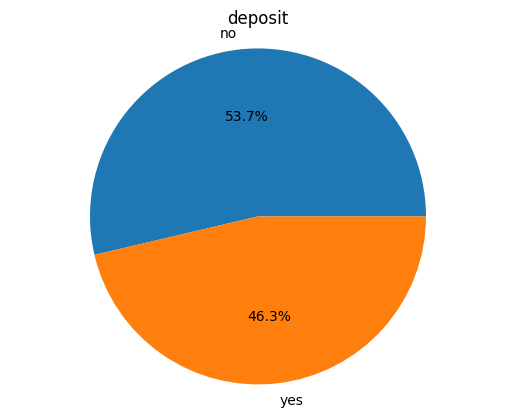

In [16]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
data = df_copy['deposit'].value_counts(normalize=True)
fig, ax = plt.subplots()
ax.pie(data, labels=data.index, autopct='%1.1f%%')
ax.axis("equal")
ax.set_title('deposit')


### Задания 2 и 3

In [17]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
print('max_age', df_copy['age'].max())
print('min_duration', df_copy['duration'].min())

max_age 95
min_duration 2


### Задания 4 и 5

(array([2617., 1104., 1418., 1385.,  335.,  780.,   93.,  319.,  709.,
         237.,  830.,  278.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <BarContainer object of 12 artists>)

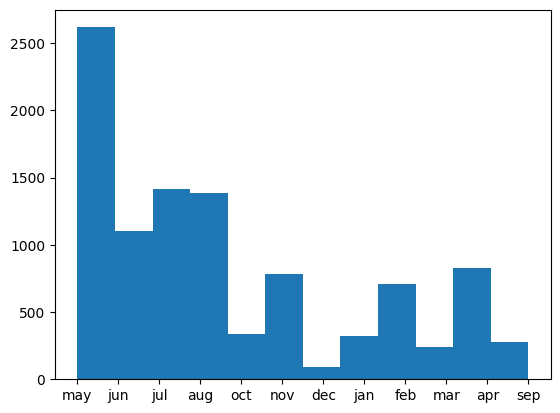

In [18]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
plt.hist(df_copy['month'], bins=12)


<AxesSubplot: >

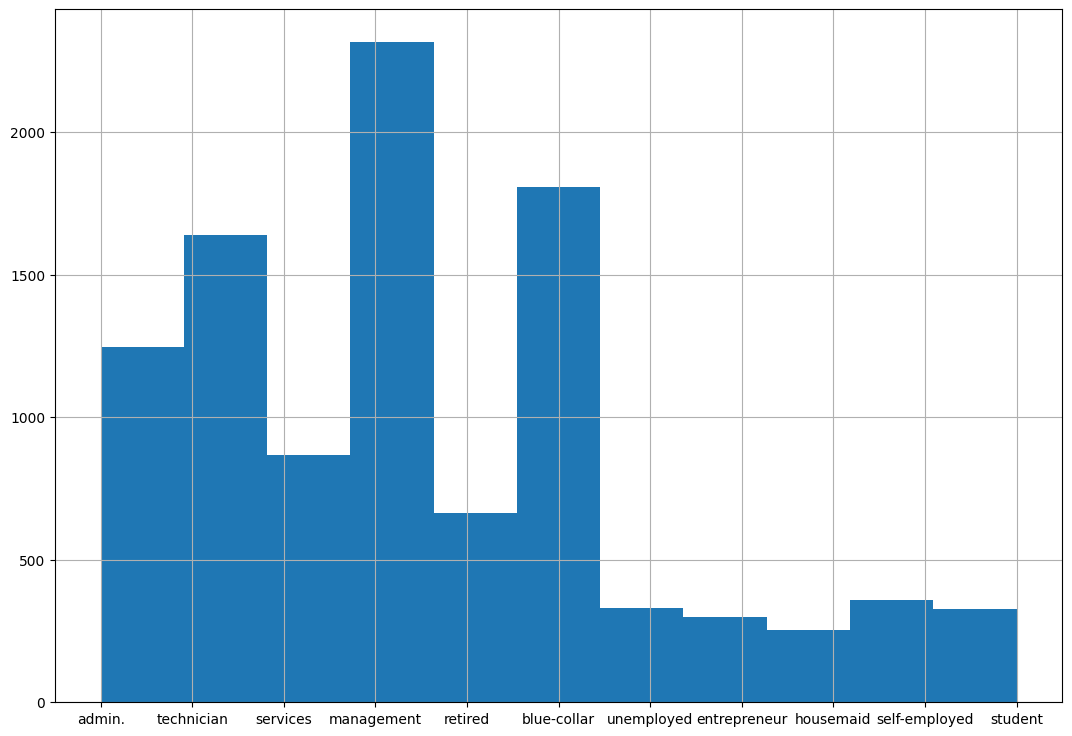

In [19]:
df_copy['job'].hist(figsize=(13,9), bins=11)


### Задание 6

In [20]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


<AxesSubplot: xlabel='poutcome'>

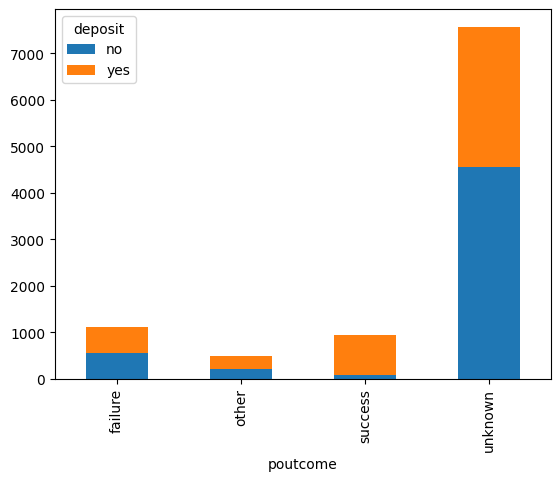

In [21]:
# Используем группировку 'deposit' по индексу 'poutcome'

types = df_copy.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

<AxesSubplot: xlabel='month'>

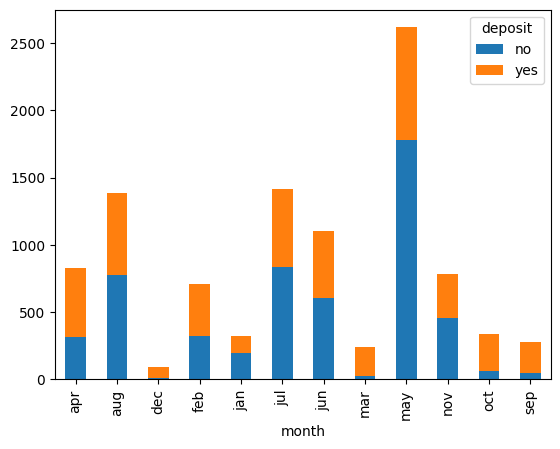

In [22]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Используем группировку 'deposit' по индексу 'poutcome'

types = df_copy.groupby("month")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 8

<AxesSubplot: xlabel='bins_age'>

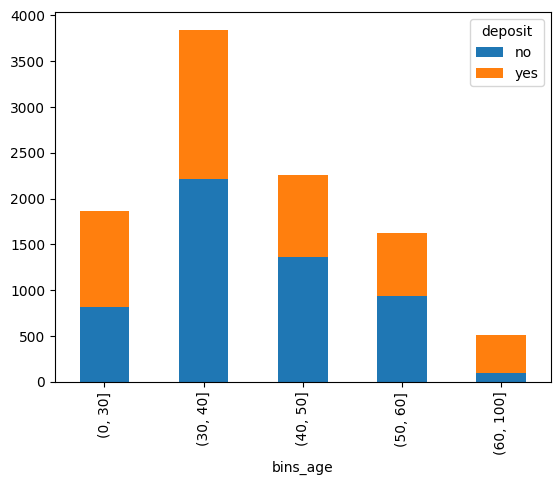

In [23]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
bins = pd.IntervalIndex.from_tuples([(0, 30), (30, 40), (40, 50), (50, 60), (60, 100)])
df_copy['bins_age'] = pd.cut(df_copy['age'], bins)
types = df_copy.groupby("bins_age")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задания 9 и 10

<AxesSubplot: xlabel='marital'>

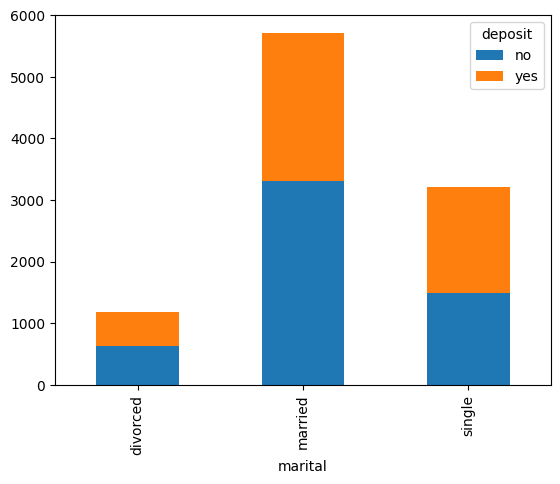

In [24]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
types = df_copy.groupby("marital")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

<AxesSubplot: xlabel='education'>

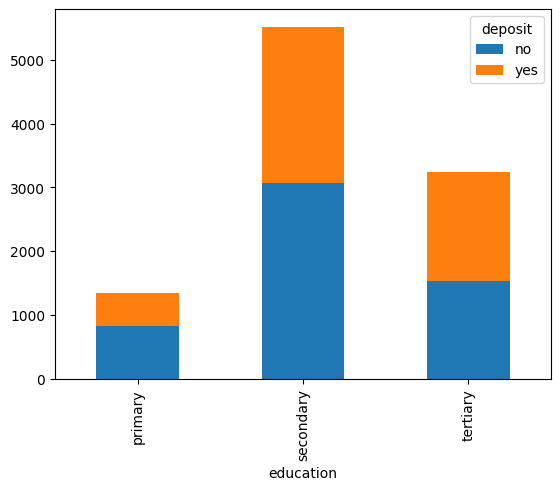

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
types = df_copy.groupby("education")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

<AxesSubplot: xlabel='job'>

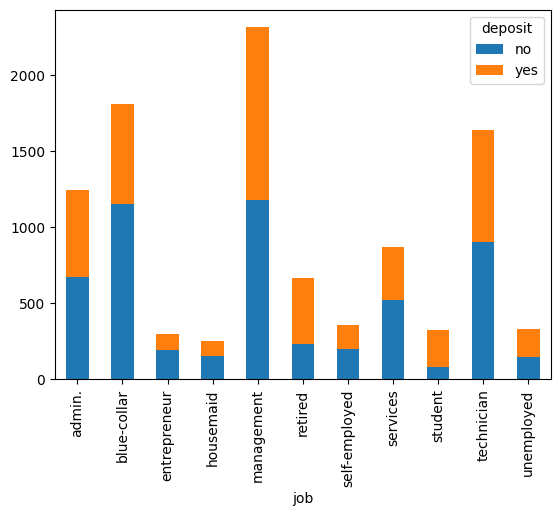

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
types = df_copy.groupby("job")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 11

In [27]:
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [28]:
df_yes = df_copy[df_copy.deposit == 'yes']
df_no = df_copy[df_copy.deposit == 'no']

Text(0.5, 1.0, 'Heatmap deposit+')

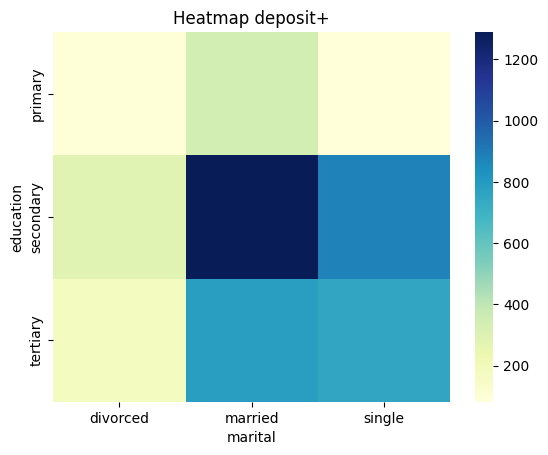

In [29]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
cross_yes = pd.crosstab(
    df_yes.education,
    df_yes.marital
)
heatmap = sns.heatmap(data=cross_yes, cmap='YlGnBu')
heatmap.set_title('Heatmap deposit+')

Text(0.5, 1.0, 'Heatmap deposit-')

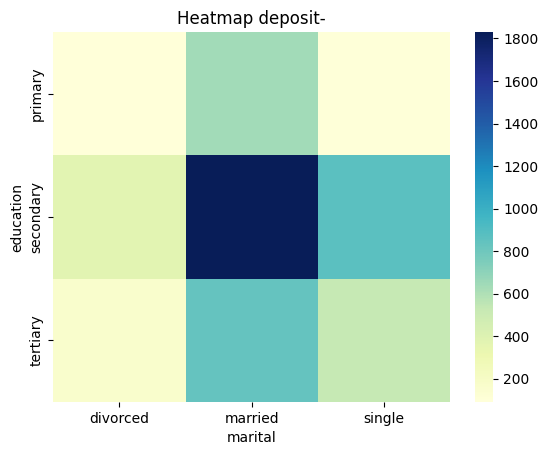

In [30]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
cross_no = pd.crosstab(
    df_no.education,
    df_no.marital
)
heatmap = sns.heatmap(data=cross_no, cmap='YlGnBu')
heatmap.set_title('Heatmap deposit-')

## Часть 3: преобразование данных

### Задание 1

In [31]:
# преобразуйте уровни образования
le = LabelEncoder()
col = ['education']
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_le = le.fit_transform(df_copy[col])


data_le = pd.DataFrame(data_le, index=df_copy.index, columns=['education_le'])
#df_copy = df_copy.reset_index().drop(['index'], axis = 1)

data_le.sum()

education_le    11995
dtype: int64

In [32]:
df_copy.shape

(10105, 18)

In [33]:
df_copy = pd.concat([df_copy,data_le], axis=1)
df_copy.shape

(10105, 19)

### Задания 2 и 3

In [34]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# преобразуйте уровни образования
le = LabelEncoder()
col = ['bins_age']
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_le = le.fit_transform(df_copy[col])


data_le = pd.DataFrame(data_le, index=df_copy.index, columns=['age_le'])
#df_copy = df_copy.reset_index().drop(['index'], axis = 1)

data_le.sum()



age_le    15279
dtype: int64

In [35]:
df_copy = pd.concat([df_copy,data_le], axis=1)
df_copy.shape

(10105, 20)

In [36]:
df_copy['deposit'] = df_copy['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
np.std(df_copy.deposit)

0.4986465781541141

In [37]:
df_copy['default'] = df_copy['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_copy['housing'] = df_copy['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_copy['loan'] = df_copy['loan'].apply(lambda x: 1 if x == 'yes' else 0)
round(df_copy['default'].mean() + df_copy['housing'].mean() + df_copy['loan'].mean(), 3)


0.635

In [38]:
df_copy['default'].value_counts()

0    9939
1     166
Name: default, dtype: int64

### Задание 4

In [39]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           10105 non-null  int64   
 1   job           10105 non-null  object  
 2   marital       10105 non-null  object  
 3   education     10105 non-null  object  
 4   default       10105 non-null  int64   
 5   balance       10105 non-null  float64 
 6   housing       10105 non-null  int64   
 7   loan          10105 non-null  int64   
 8   contact       10105 non-null  object  
 9   day           10105 non-null  int64   
 10  month         10105 non-null  object  
 11  duration      10105 non-null  int64   
 12  campaign      10105 non-null  int64   
 13  pdays         10105 non-null  int64   
 14  previous      10105 non-null  int64   
 15  poutcome      10105 non-null  object  
 16  deposit       10105 non-null  int64   
 17  bins_age      10105 non-null  category
 18  educat

In [40]:
df_copy = df_copy.drop(['education', 'age', 'bins_age'], axis=1)

In [41]:
# создайте дамми-переменные
cols = ['job', 'marital', 'contact', 'month', 'poutcome']
dummies_data = pd.get_dummies(df_copy, columns=cols)
dummies_data.head()

,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,2343.0,1,0,5,1042,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
1,0,45.0,0,0,5,1467,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0,1270.0,1,0,5,1389,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0,2476.0,1,0,5,579,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,184.0,0,0,5,673,2,-1,0,1,...,0,0,1,0,0,0,0,0,0,1


In [42]:
dummies_data.columns

Index(['default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign',
       'pdays', 'previous', 'deposit', 'education_le', 'age_le', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задания 5 и 6

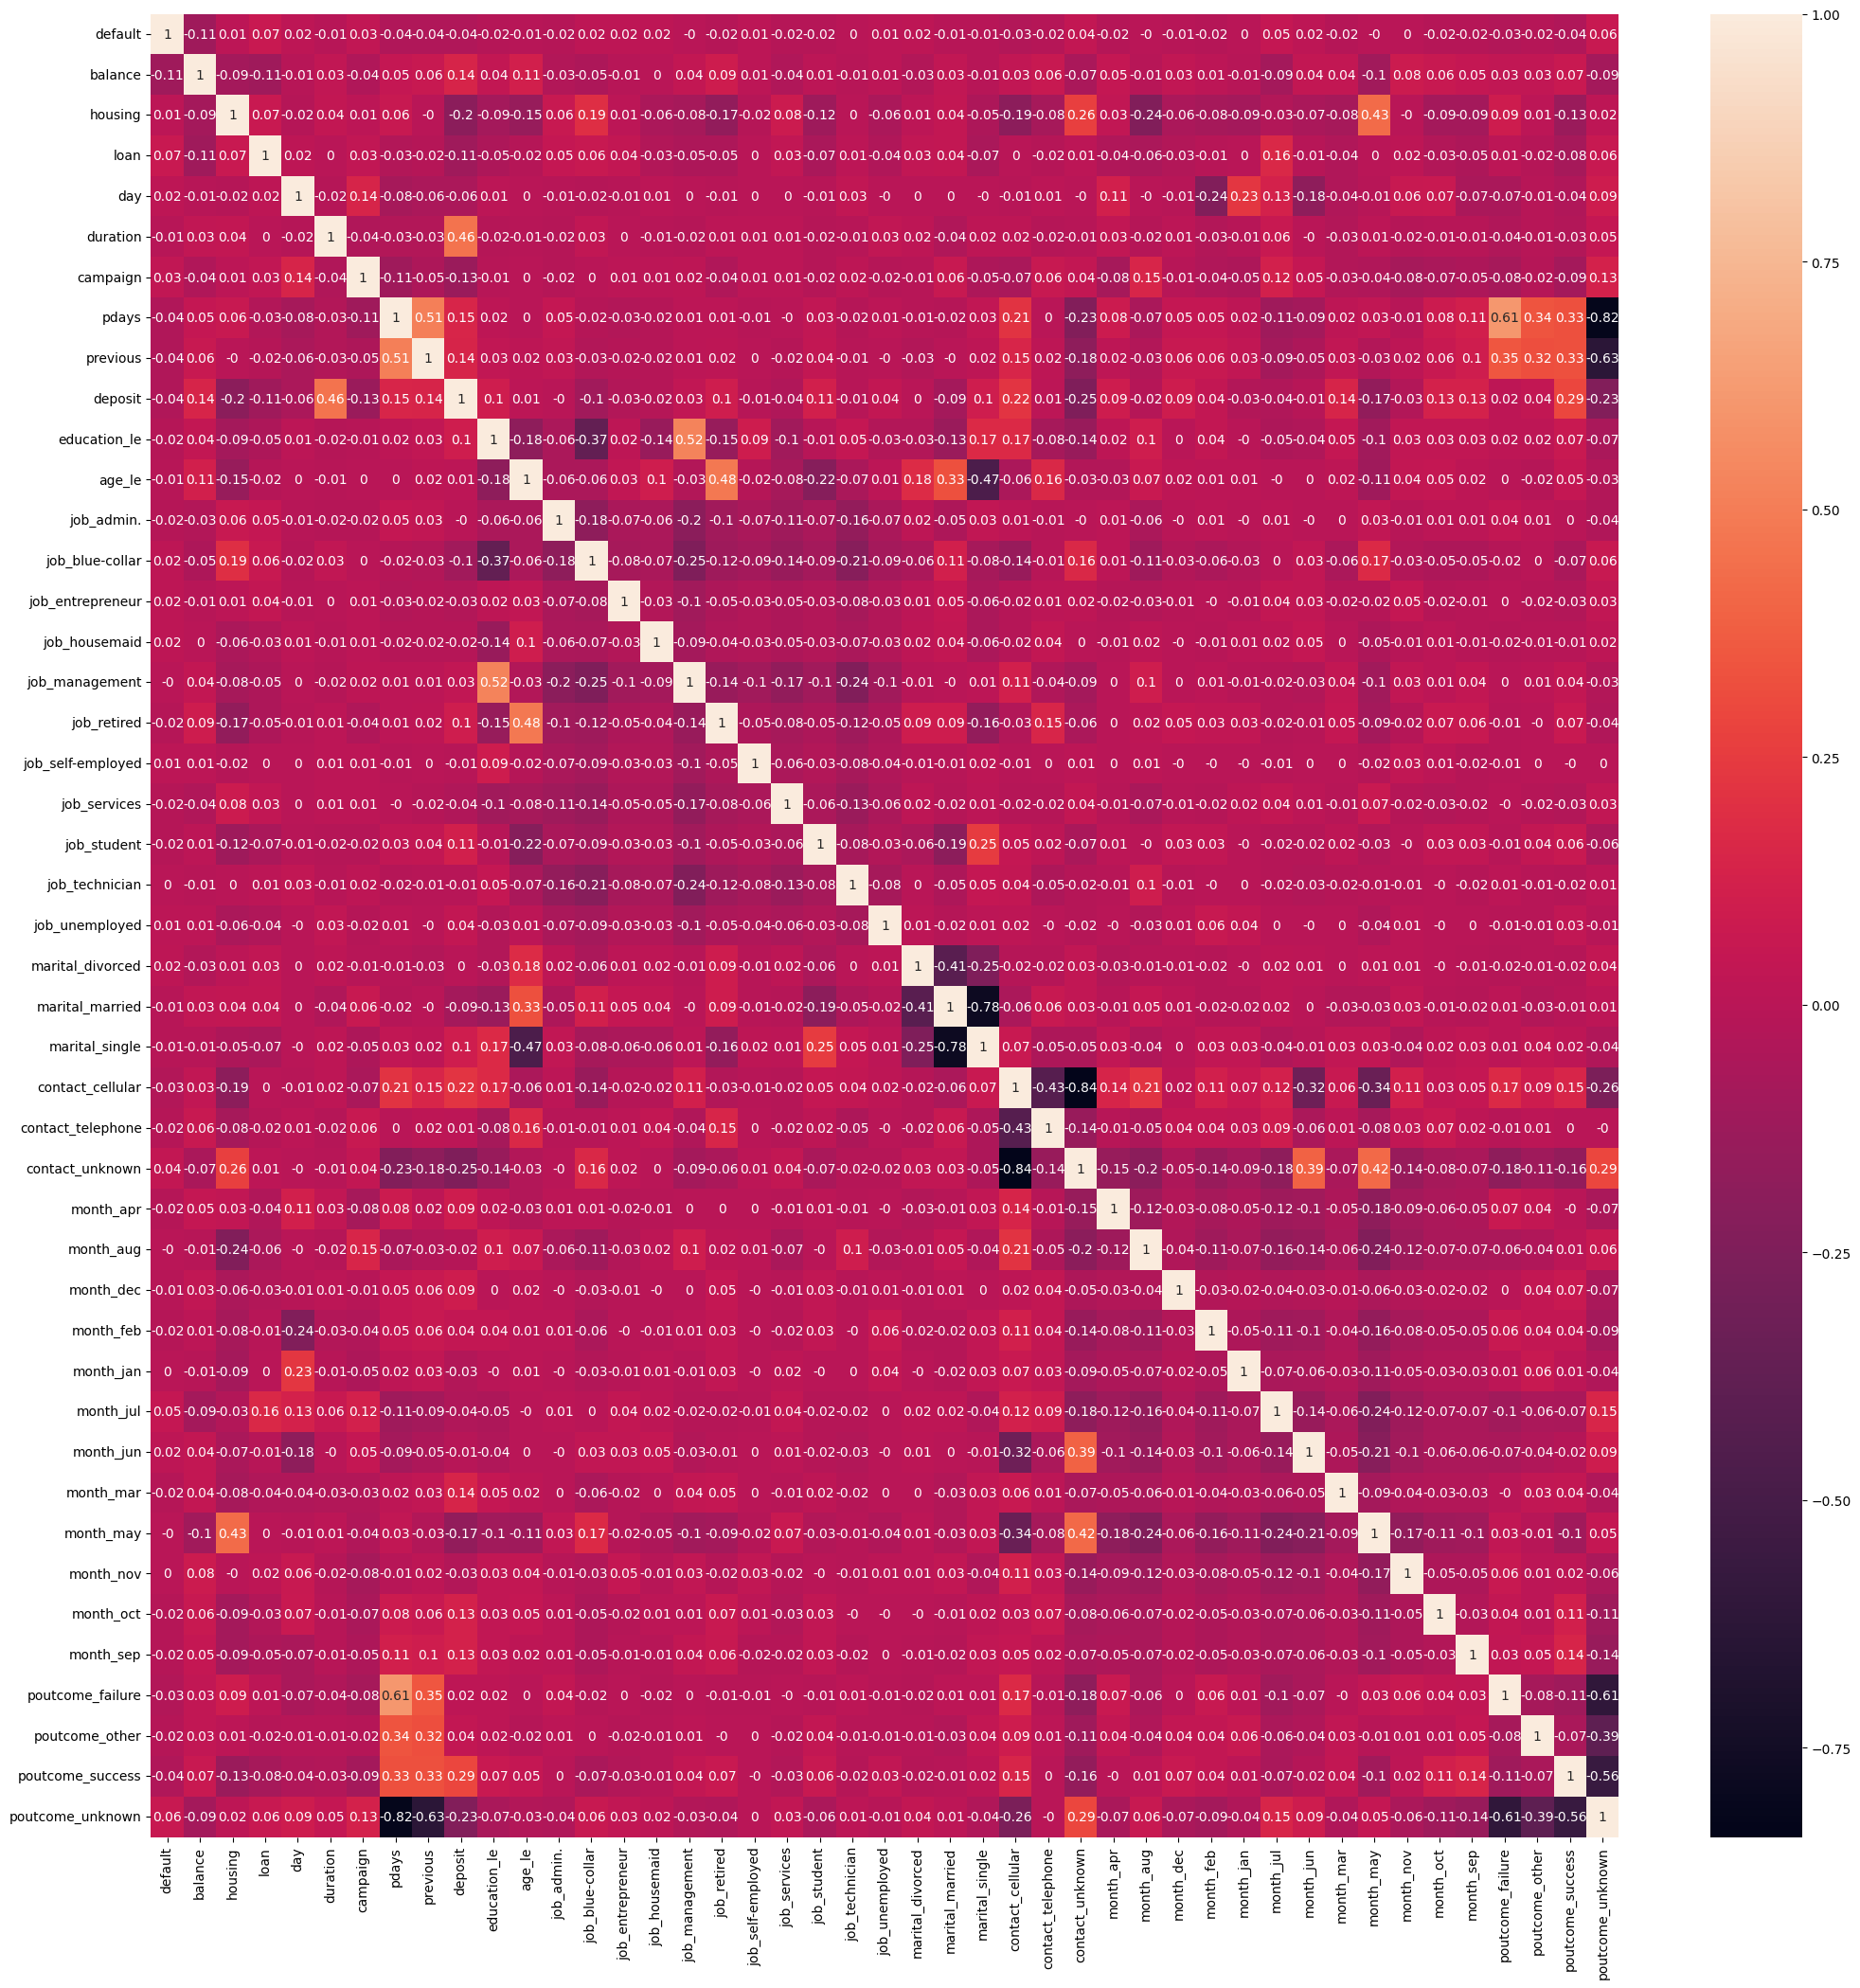

In [43]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (25, 25))
sns.heatmap(dummies_data.corr().round(2), annot = True);

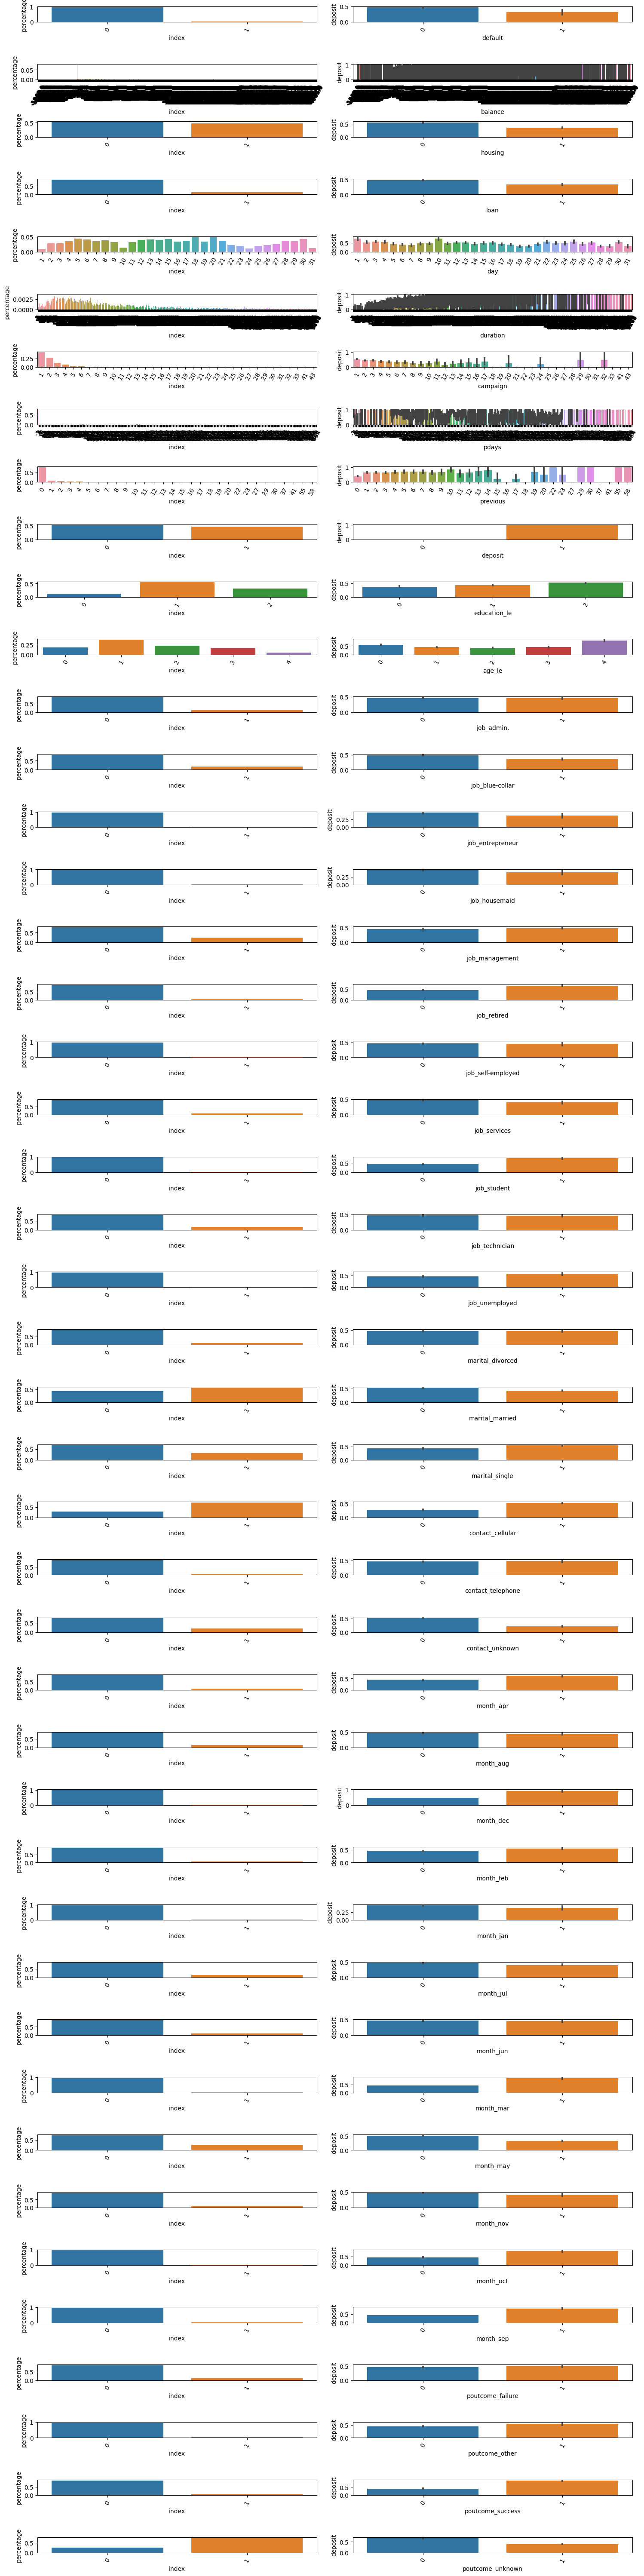

In [44]:
n = len(dummies_data.columns) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 60)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(dummies_data.columns):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (dummies_data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=dummies_data, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задания 7 и 8

In [45]:
X = dummies_data.drop(['deposit'], axis=1)
y = dummies_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [46]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 44)

In [47]:
y_test.mean().round(2)

0.46

### Задание 9

In [48]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
cols_kbest = selector.get_feature_names_out()
cols_kbest

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [49]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[cols_kbest])
X_train_scaled = scaler.transform(X_train[cols_kbest])
X_test_scaled = scaler.transform(X_test[cols_kbest])

In [50]:
X_test_scaled_dr = pd.DataFrame(X_test_scaled, index=X_test.index)

In [51]:
X_test_scaled_dr.iloc[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [52]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=42, solver='sag')
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

f1_score на тестовом наборе: 0.78
accuracy на тестовом наборе: 0.80
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [53]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_test_scaled)
#Выводим значения метрик
print(metrics.classification_report(y_test, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [54]:
train_sizes = range(2,20,1)
train_scores_mean = []
valid_scores_mean = []

for i in train_sizes:
    #Создаём модель
    model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=i,
    random_state=42, #генератор случайных чисел
    )
    #Обучаем модель на тренировочной выборке
    model.fit(X_train_scaled, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train_scaled)
    y_valid_pred = model.predict(X_test_scaled)
    
    train_scores_mean.append(metrics.accuracy_score(y_train, y_train_pred))
    valid_scores_mean.append(metrics.accuracy_score(y_test, y_valid_pred))

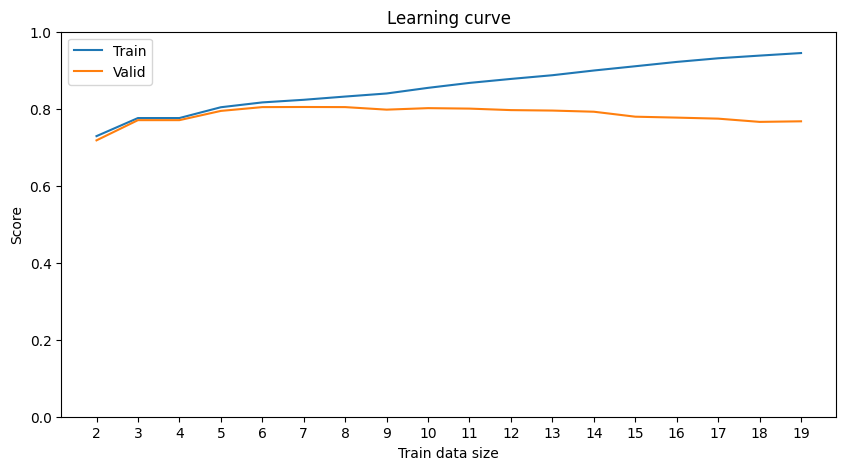

In [55]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

In [56]:
print('best_score ', train_scores_mean[4].round(2))

best_score  0.82


### Задание 5

In [57]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_distributions = {'min_samples_leaf': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
            
random_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(    criterion='entropy', #критерий информативности
random_state=42), 
    param_grid=param_distributions, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: user 142 ms, sys: 286 ms, total: 428 ms
Wall time: 1.65 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_leaf': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [58]:
# обучите на ваших данных случайный лес
''''n_estimators = 100;
criterion = 'gini';
min_samples_leaf = 5;
max_depth = 10;
random_state = 42.'''
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, #list
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scaled, y_train)
 
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [59]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
''''learning_rate = 0.05;
n_estimators = 300;
min_samples_leaf = 5;
max_depth = 5;
random_state = 42.
'''
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    min_samples_leaf = 5,
    learning_rate = 0.05,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [60]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(
        max_iter = 1000, 
        random_state=42, 
        solver='sag')),
    ('dt',  tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42, #генератор случайных чисел
    )),
    ('rf', ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, #list
    random_state=42 #генератор случайных чисел
    ))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(max_iter = 1000, random_state=42, solver='sag')
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по f1 для стекинга {round(metrics.precision_score(y_test, y_pred_stack), 2)}')
print(metrics.classification_report(y_test, y_pred_stack))

Качество предсказания по f1 для стекинга 0.81
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

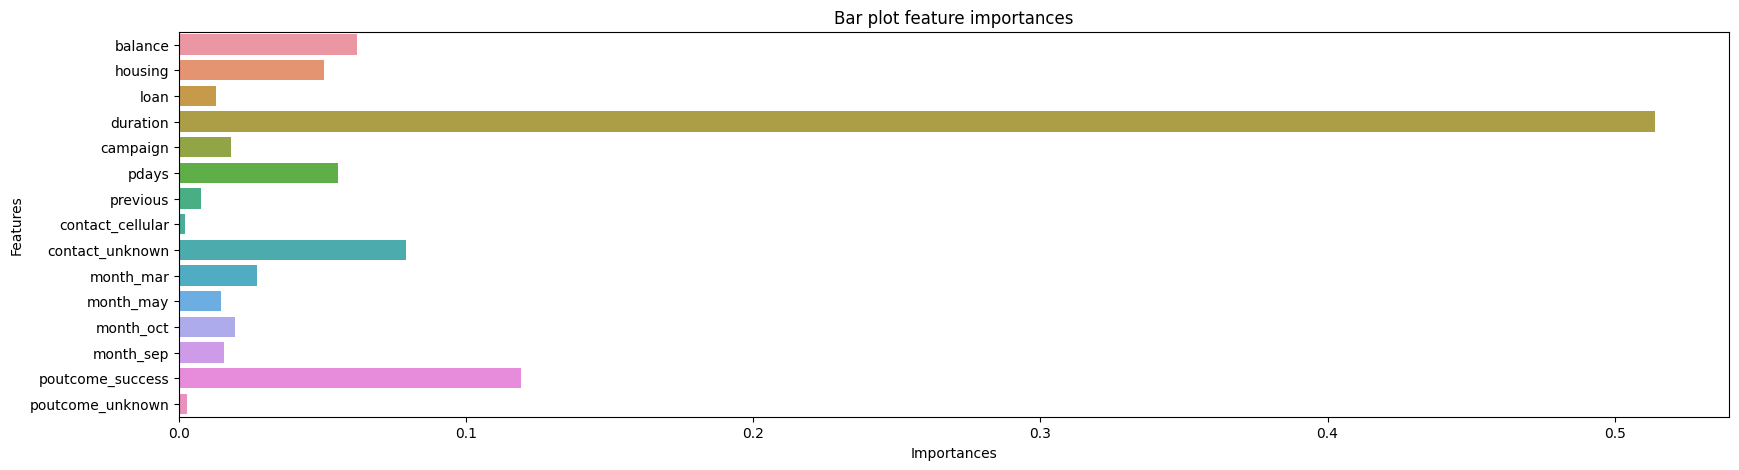

In [84]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(20, 5)) #фигура + координатная плоскость
feature = X_test[cols_kbest].columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax, orient='h');
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_ylabel('Features')
ax.set_xlabel('Importances');

### Задания 6,7,8

In [62]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.0


In [63]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  

In [64]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-04-09 01:04:25,776] A new study created in memory with name: RandomForestClassifier
[I 2023-04-09 01:04:26,651] Trial 0 finished with value: 0.8602586072596978 and parameters: {'n_estimators': 196, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8602586072596978.
[I 2023-04-09 01:04:27,312] Trial 1 finished with value: 0.8429262205584152 and parameters: {'n_estimators': 142, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8602586072596978.
[I 2023-04-09 01:04:27,964] Trial 2 finished with value: 0.8728179551122195 and parameters: {'n_estimators': 107, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8728179551122195.
[I 2023-04-09 01:04:28,988] Trial 3 finished with value: 0.859504132231405 and parameters: {'n_estimators': 187, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8728179551122195.
[I 2023-04-09 01:04:29,766] Trial 4 finished with value: 0.8940221632589355 and parameters: {'n_

CPU times: user 13.8 s, sys: 12.5 ms, total: 13.8 s
Wall time: 13.8 s


In [65]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 128, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [66]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
